<a href="https://colab.research.google.com/github/treiro/Unet-ISBI-Keras/blob/main/ISBI_UNET.v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%ls

sample_data/


In [4]:
%cp -r gdrive/MyDrive/COLAB/Unet/UNET-ISBI-KERAS/* .

## Data augmentation

In [5]:
from data import *
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGenerator = trainGenerator(20,'data/membrane/train','image','label',data_gen_args,save_to_dir = "data/membrane/train/aug")
print(myGenerator)

<generator object trainGenerator at 0x7f2ba8b57e50>


## visualize your data augmentation result

In [6]:
#you will see 60 transformed images and their masks in data/membrane/train/aug
num_batch = 3
for i,batch in enumerate(myGenerator):
    if(i >= num_batch):
        break

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


## Design Model

In [7]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [8]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [7]:
def unet(pretrained_weights = None,input_size = (256,256,1), lr=1e-4):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2),strides=2)(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2),strides=2)(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2),strides=2)(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2),strides=2)(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

          
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), activation = 'relu', padding="valid",kernel_initializer = 'he_normal')(drop5)
    merge6 = concatenate([drop4[:,4:60,4:60,:],up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), activation = 'relu', padding="valid",kernel_initializer = 'he_normal')(conv6)
    merge7 = concatenate([conv3[:,16:120,16:120,:],up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), activation = 'relu', padding="valid",kernel_initializer = 'he_normal')(conv7)
    merge8 = concatenate([conv2[:,40:240,40:240,:],up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), activation = 'relu', padding="valid",kernel_initializer = 'he_normal')(conv8)
    merge9 = concatenate([conv1[:,88:480,88:480,:],up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(1, 1, padding = 'valid', activation = 'sigmoid', kernel_initializer = 'he_normal')(conv9)
    # conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv9)

    model.compile(optimizer = Adam(lr = lr), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

## Train model

In [9]:
# model = unet()
model_checkpoint = ModelCheckpoint('model-isbi.h5', monitor='loss',verbose=1, save_best_only=True)
input_img = Input((256, 256, 1), name='img')
model = get_unet(input_img, n_filters=64, dropout=0.05, batchnorm=True)

callbacks = [
    EarlyStopping(patience=2, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-isbi.h5', verbose=1, save_best_only=True, save_weights_only=True)
]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [20]:
results  =  model.fit_generator(myGenerator,steps_per_epoch=300,epochs=5,callbacks=[model_checkpoint])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
300/300 [==============================] - 310s 1s/step - loss: 0.1154 - accuracy: 0.9498

Epoch 00001: loss improved from 0.18258 to 0.11542, saving model to model-isbi.h5
Epoch 2/5
300/300 [==============================] - 309s 1s/step - loss: 0.0883 - accuracy: 0.9616

Epoch 00002: loss improved from 0.11542 to 0.08832, saving model to model-isbi.h5
Epoch 3/5
300/300 [==============================] - 310s 1s/step - loss: 0.0759 - accuracy: 0.9670

Epoch 00003: loss improved from 0.08832 to 0.07591, saving model to model-isbi.h5
Epoch 4/5
300/300 [==============================] - 309s 1s/step - loss: 0.0687 - accuracy: 0.9701

Epoch 00004: loss improved from 0.07591 to 0.06870, saving model to model-isbi.h5
Epoch 5/5
300/300 [==============================] - 308s 1s/step - loss: 0.0640 - accuracy: 0.9721

Epoch 00005: loss improved from 0.06870 to 0.06398, saving model to model-isbi.h5


## Accuracy-Loss

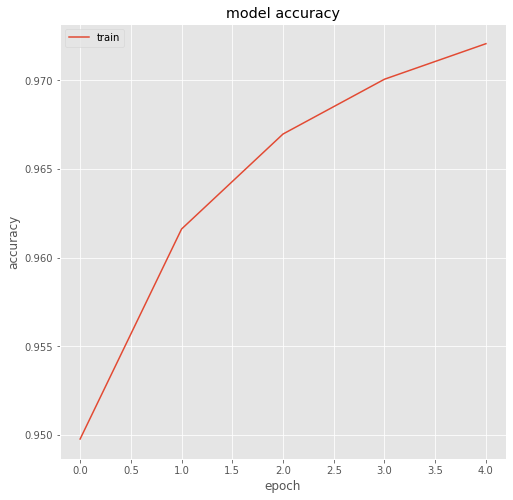

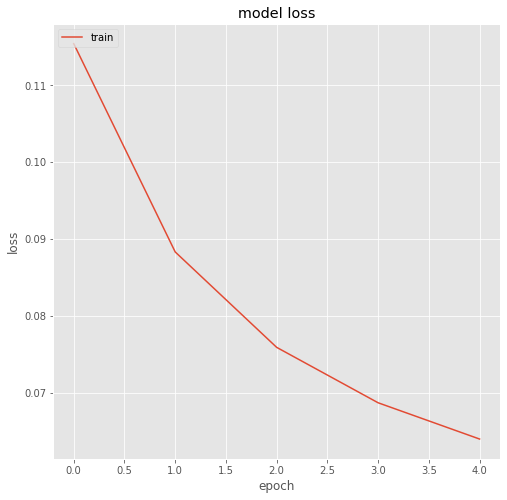

In [21]:
#  "Accuracy"
plt.figure(figsize=(8, 8))
plt.plot(results.history['accuracy'])
# plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('unet_final_4_acc')
plt.show()
# "Loss"
plt.figure(figsize=(8, 8))
plt.plot(results.history['loss'])
# plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('unet_final_4_loss')
plt.show()


##  Test

In [22]:
testGene = testGenerator("data/membrane/test")
results = model.predict_generator(testGene,30,verbose=1)
saveResult("data/membrane/test",results)

 3/30 [==>...........................] - ETA: 1s

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


30/30 [==============================] - 1s 36ms/step


##  Predic Image on on test

In [23]:
# load the best model
model.load_weights('model-isbi.h5')

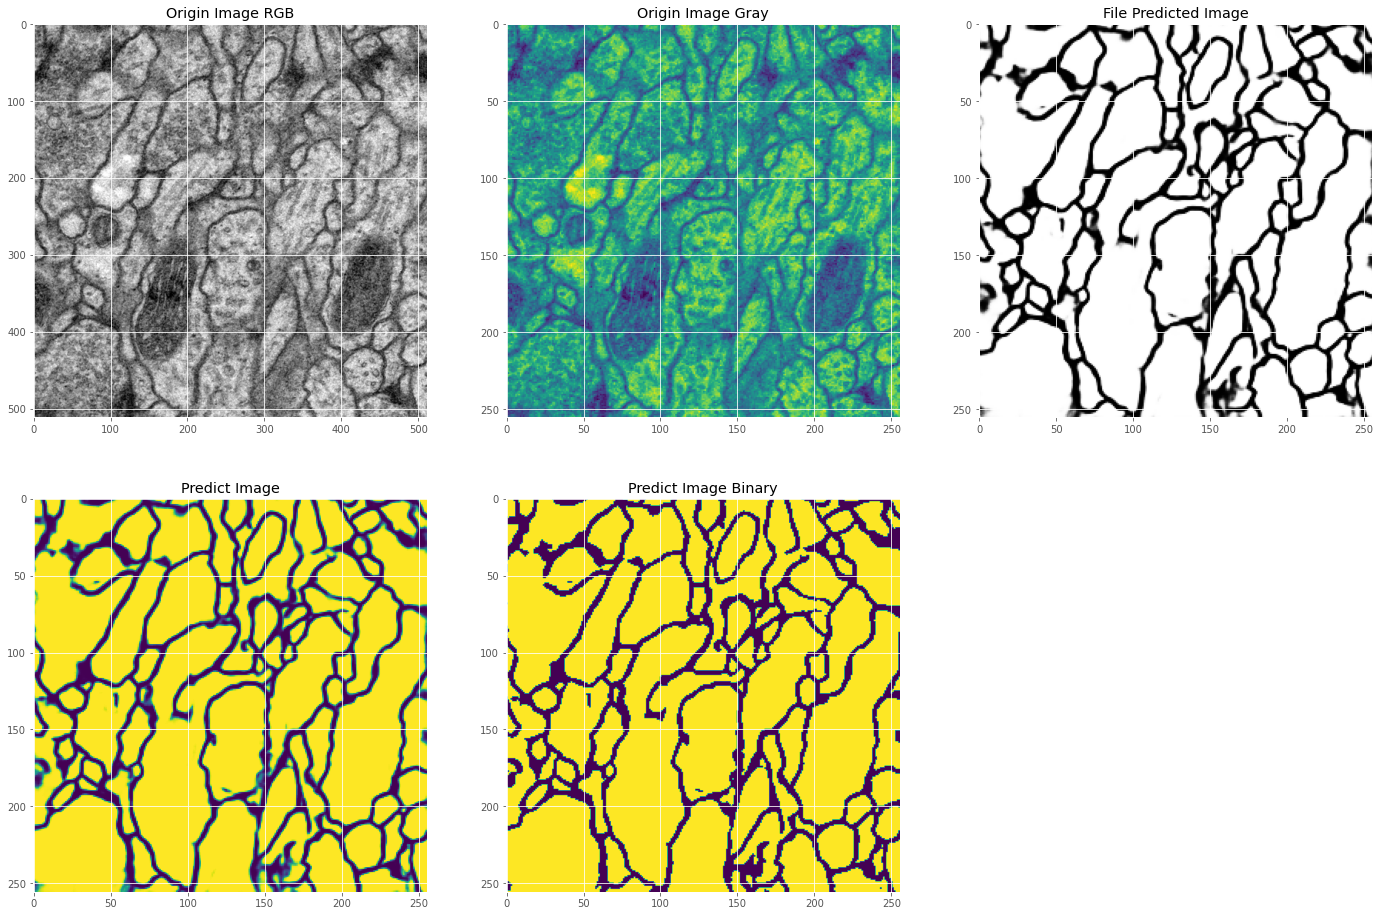

In [27]:

import glob2
import cv2
INPUT_SHAPE  =  256
test_paths = glob2.glob('data/membrane/test/*.png')
test_paths = [path for path in test_paths if 'predict' not in path]

rand_ind = np.random.randint(20)
path = test_paths[rand_ind]
mask_path = path.replace('.png','_predict.png')
def predict_path(path, mask_path, figsize = (24, 16)):
  img_rgb = cv2.imread(path)
  #Read as Gray 
  img = cv2.imread(path, 0)
  img = img / 255
  img = cv2.resize(img, (INPUT_SHAPE, INPUT_SHAPE), cv2.INTER_LINEAR)
  img_expand = img[np.newaxis, ...]

  mask_rgb = cv2.imread(mask_path)
  mask = cv2.imread(mask_path)
  mask = cv2.resize(mask, (INPUT_SHAPE, INPUT_SHAPE), cv2.INTER_LINEAR)

  img_pred = model.predict(img_expand).reshape(INPUT_SHAPE, INPUT_SHAPE)
  # img_pred[img_pred < 0.5] = 0
  # img_pred[img_pred >= 0.5] = 1
  img_pred_binary = img_pred > 0.5
  plt.subplots(figsize = figsize)
  plt.subplot(2,3,5)
  plt.title('Predict Image Binary')
  plt.imshow(img_pred_binary)

  plt.subplot(2,3,4)
  plt.title('Predict Image')
  plt.imshow(img_pred)

  plt.subplot(2,3,3)
  plt.title('File Predicted Image')
  plt.imshow(mask)

  plt.subplot(2,3,2)
  plt.title('Origin Image Gray')
  plt.imshow(img)

  plt.subplot(2,3,1)
  plt.title('Origin Image RGB')
  plt.imshow(img_rgb)

predict_path(path, mask_path)